# The Effects of a Changing Environment on the Spectra of Mars Analog Samples

This work constitutes the data analysis section for my MSc thesis at UCL (currently in progress, due August 2024). My project is advised by Dr Louisa Preston, with support from Professor Lewis Dartnell and Connor Ballard.

In this notebook, I will be analysing how lyophilization affects the spectra of Mars analog samples. This analysis includes:

* Mid-IR spectra collected at the Mullard Space Science Laboratory using the Agilent 4300 Handheld FTIR spectrometer, docked onto a table-top setup and equipped with a Diamond-ATR sampling module.
* Vis-NIR spectra collected at the University of Westminster using the RxSpec 700Z spectrometer. There are spectral joins in this data at $1000cm^{-1}$ and $1850cm^{-1}$, so features around these wavenumbers should be disregarded in analysis. 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir

## Samples

I am analysing sandstone from Antarctica (denoting Antarctica crytoendolith sandstone as ACE SST) and <a href="https://doi.org/10.1016/j.icarus.2023.115568">SOPHIA</a> (Simulant for Oxia Planum: Hydrated, Igneous, and Amorphous). I also analyse the spectra for a microbial mat collected on the Robert Falcon Scott expedition to Antarctica in 1910. For the SOPHIA sample, I analyse the spectra with and without microbes from the mat mixed in. For each sample, I collected multiple spectra to analyse different parts of the sample. These are labeled as subsamples (SS). I label the samples as: 

* ACE SST BP5 - crustal layer of Antarctica sandstone sample from study BP5
* ACE SST BP6 - crustal layer of Antarctica sandstone sample from study BP6
* ACE SST BLACK - black layer of Antarctica sandstone sample
* SCOTT MAT - microbial mat from the Scott expedition
* SOPHIA - simulant
* SOPHIA MAT - simulant with microbial mat mixed in

In [4]:
def load_spectra(dir, delimiter, skiprows = 0):
    result = {}

    for sample in listdir(dir):
        result[sample] = []
        
        for subsample in listdir(dir + sample):
            data = np.loadtxt(dir + sample + '/' + subsample, delimiter=delimiter, skiprows=skiprows)
            data = np.transpose(data)
            result[sample].append(data)
    
    return result

In [5]:
BEFORE_MIR = load_spectra('./Data/BEFORE LYO/MID IR/', ',', 21)

In [6]:
# TODO
# AFTER_MIR = load_spectra('./Data/AFTER LYO/MID IR/', ',')

In [7]:
BEFORE_VIS_NIR = load_spectra('./Data/BEFORE LYO/VIS NIR/', '\t')

In [8]:
AFTER_VIS_NIR = load_spectra('./Data/AFTER LYO/VIS NIR/', '\t')

## Plotting Functions

## VIS-NIR Analysis

In [9]:
def plot_sample(samples, title):
    for sample, subsamples in samples.items():
        fig, ax = plt.subplots()

        ax.set_title(title + ': ' + sample)
        ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Reflectance')
        ssLabel = 1

        for curr_intensity, intensity in subsamples:
            ax.plot(curr_intensity, intensity, label='SS ' + str(ssLabel))
            ssLabel += 1
        
        ax.invert_xaxis()
        ax.legend()
        
        fig.savefig('./Spectra/' + title + '/' + sample + '.png')

### Before Lyophilization

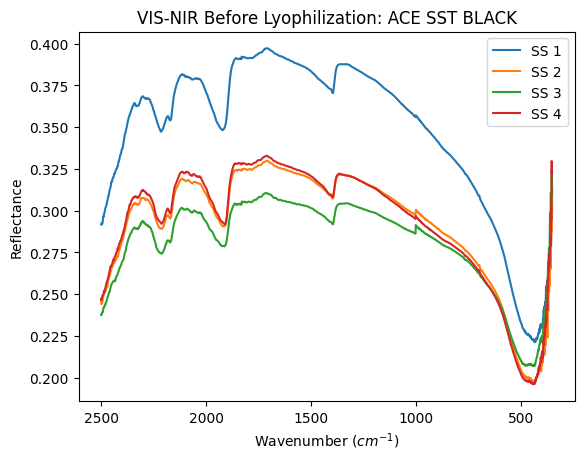

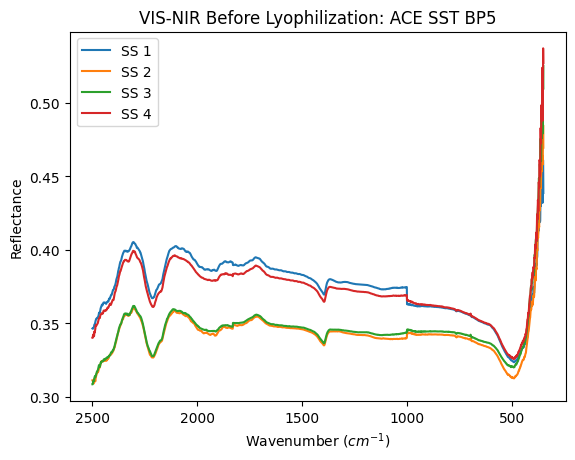

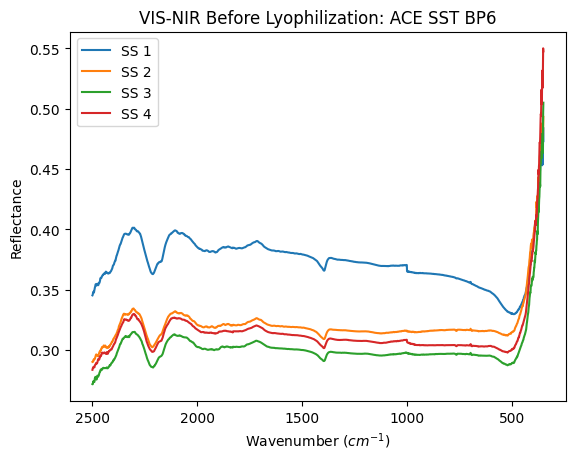

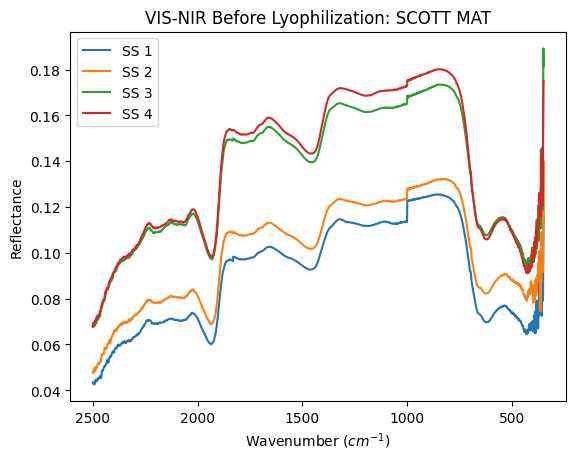

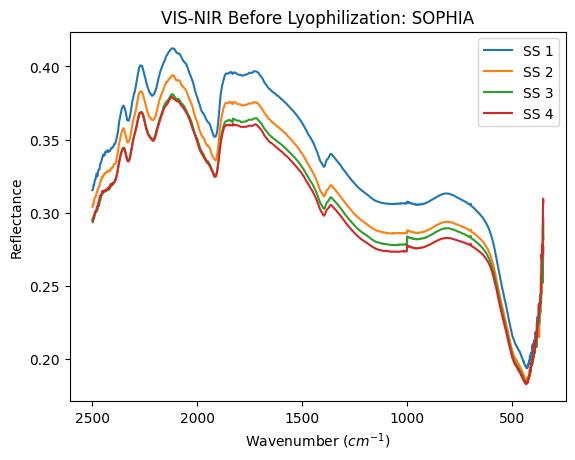

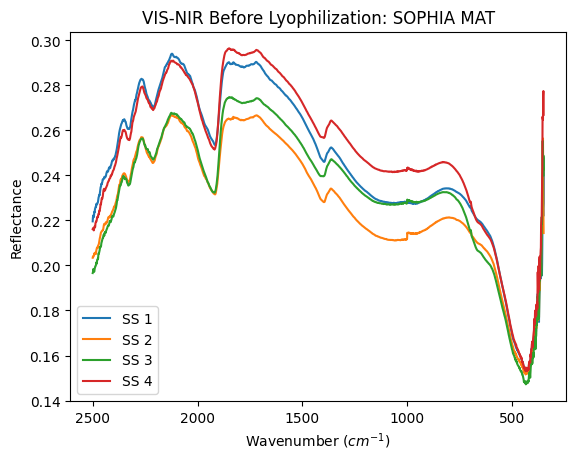

In [10]:
plot_sample(BEFORE_VIS_NIR, 'VIS-NIR Before Lyophilization')

### After Lyophilization

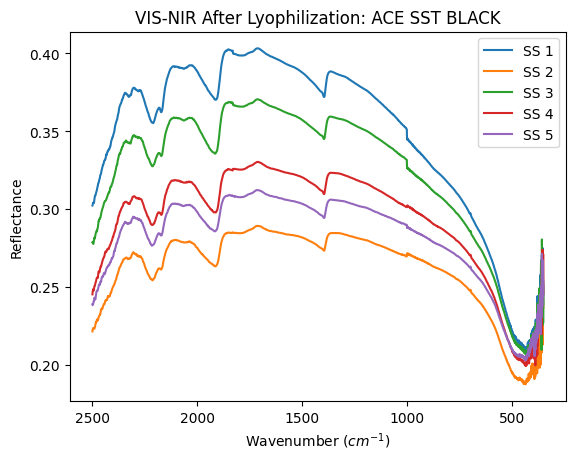

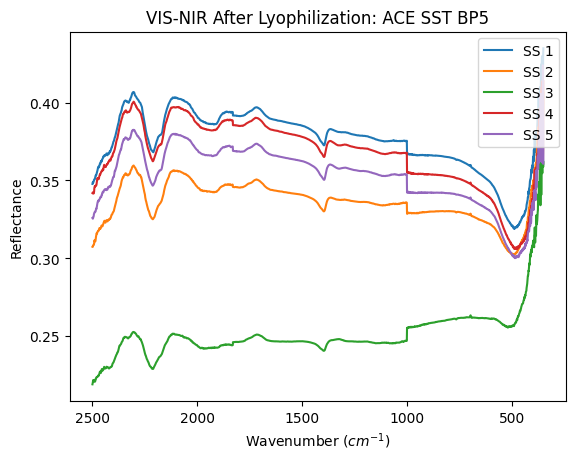

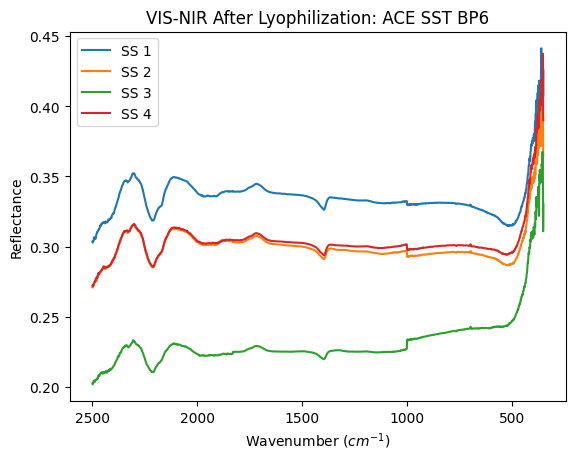

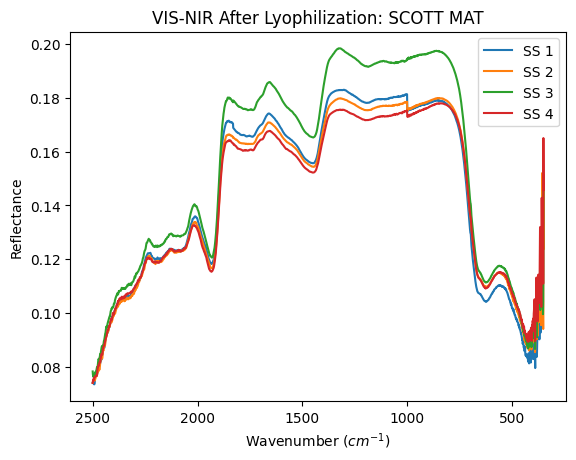

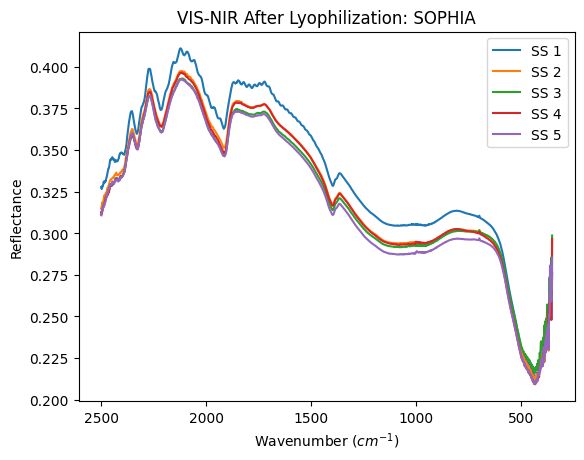

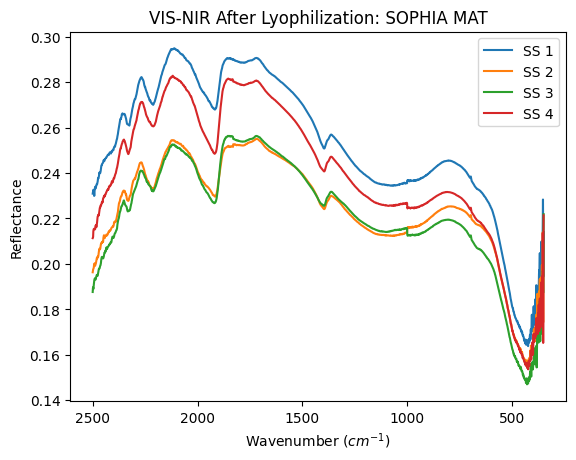

In [11]:
plot_sample(AFTER_VIS_NIR, 'VIS-NIR After Lyophilization')


### Comparison

#### Direct

In [12]:
def plot_before_after(before, after, parse_data=None):
    for sample_before, subsamples_before in before.items():
        subsamples_after = after[sample_before]
        fig, ax = plt.subplots()
        ax.set_title(sample_before)
        ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Reflectance')
        ssLabel = 1

        for curr_intensity, intensity in subsamples_before:
            if (parse_data):
                intensity =  parse_data(intensity)

            ax.plot(curr_intensity, intensity, '--', label='SS ' + str(ssLabel) + ' (before)')
            ssLabel += 1

        ssLabel = 1
        for curr_intensity, intensity in subsamples_after:
            if (parse_data):
                intensity =  parse_data(intensity)
                
            ax.plot(curr_intensity, intensity, '-', label='SS ' + str(ssLabel) + ' (after)')
            ssLabel += 1
        
        ax.invert_xaxis()
        ax.legend()

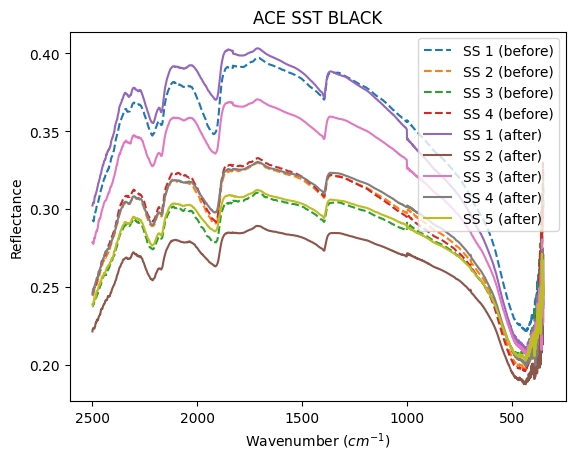

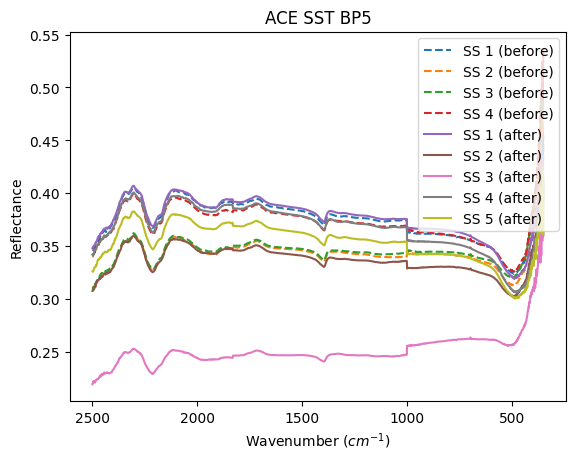

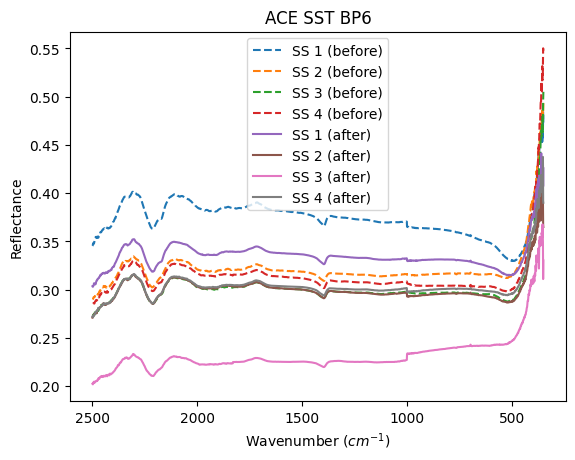

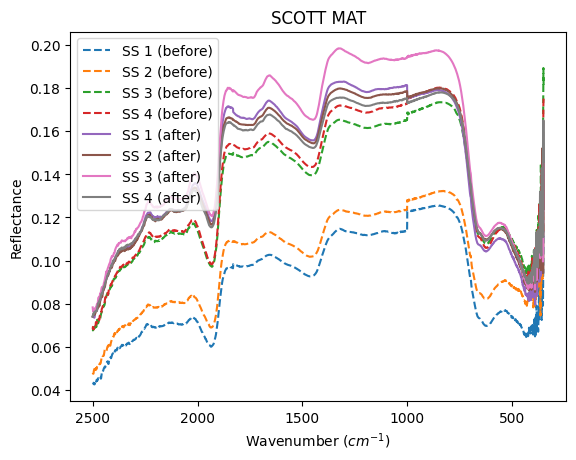

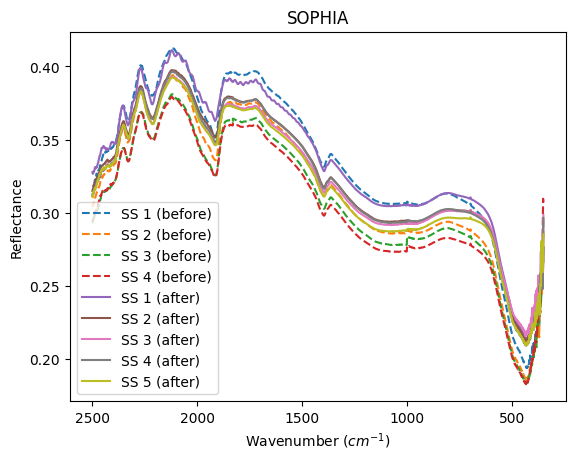

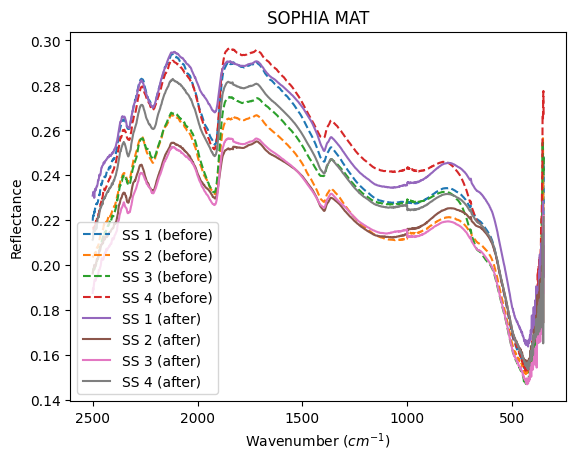

In [13]:
plot_before_after(BEFORE_VIS_NIR, AFTER_VIS_NIR)

#### Average Removed

The plots comparing the spectra show similar shapes but it is difficult to see the differences because the reflectance of each subsample has varying baselines. To better visualise this, for each subsample we can remove the average reflectance intensity from each wavenumber. This brings all the subsamples to the sample baseline. 

In [14]:
def remove_average(data):
    average = sum(data) / len(data)

    result = []

    for value in data:
        result.append(value - average)

    return result

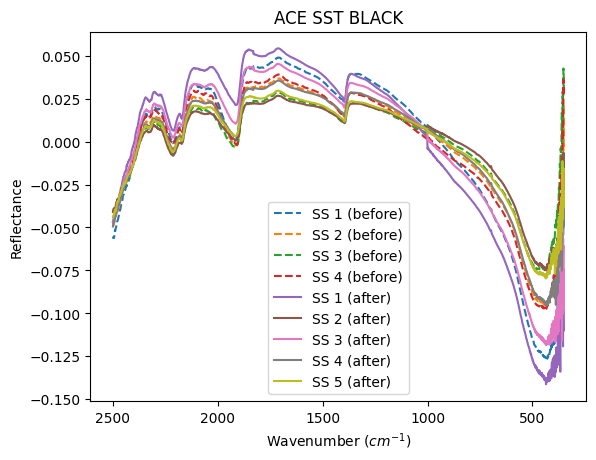

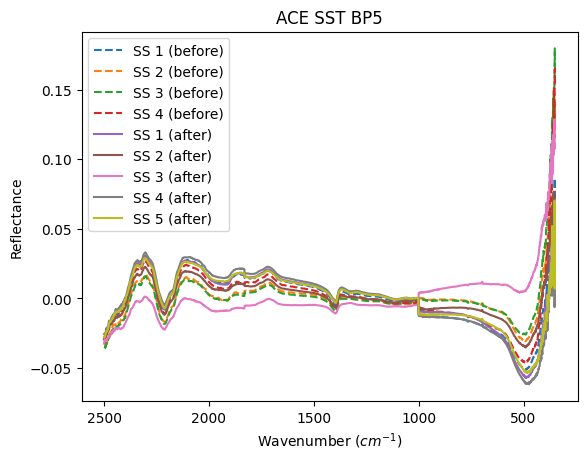

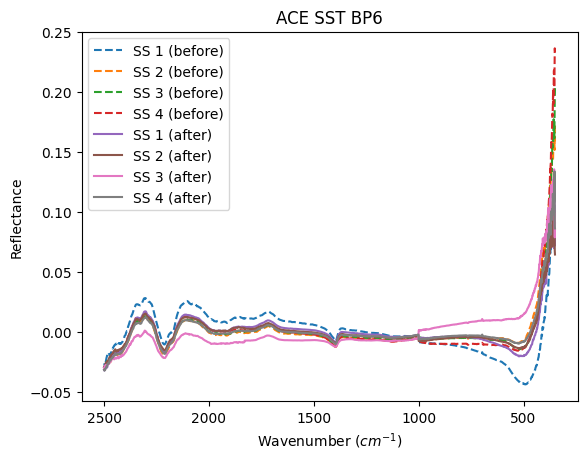

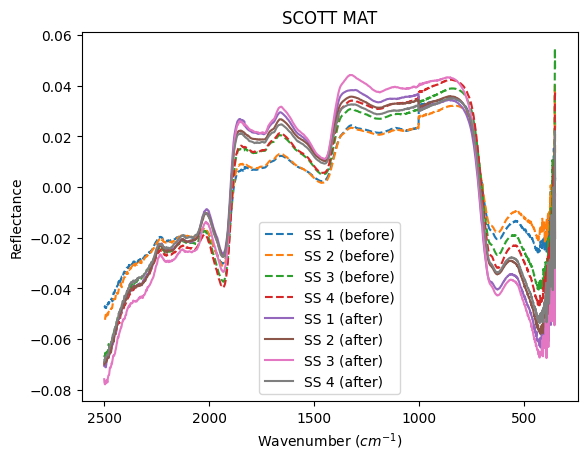

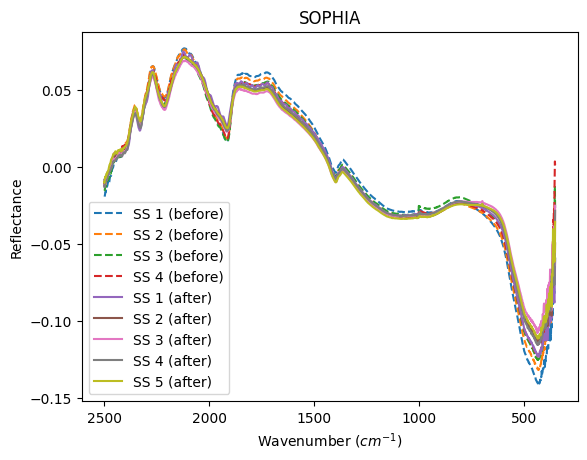

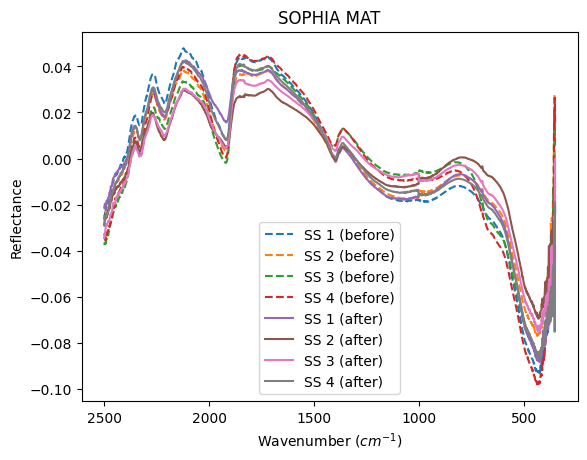

In [15]:
plot_before_after(BEFORE_VIS_NIR, AFTER_VIS_NIR, remove_average)

#### Subsamples Averaged

In [16]:
def get_subsamples_avg(subsamples, parse_data):
    result = [0] * len(subsamples[0][0])

    for i in range(len(subsamples)):
        intensities = subsamples[i][1]
        if (parse_data):
            intensities =  parse_data(intensities)
        
        for j in range(len(intensities)):
            result[j] += intensities[j]

    for i in range(len(result)):
        result[i] /= len(subsamples)

    return result

def plot_before_after_ss_avg(before, after, parse_data=None):
    for sample_before, subsamples_before in before.items():
        subsamples_after = after[sample_before]
        fig, ax = plt.subplots()
        ax.set_title(sample_before)
        ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Reflectance')

        wavenumbers = list(subsamples_before)[0][0]

        avg_intensity_before = get_subsamples_avg(list(subsamples_before), parse_data)
        avg_intensity_after = get_subsamples_avg(list(subsamples_after), parse_data)

        ax.plot(wavenumbers, avg_intensity_before, '--', label='Avg before')
        ax.plot(wavenumbers, avg_intensity_after, '-', label='Avg after')
        
        ax.invert_xaxis()
        ax.legend()

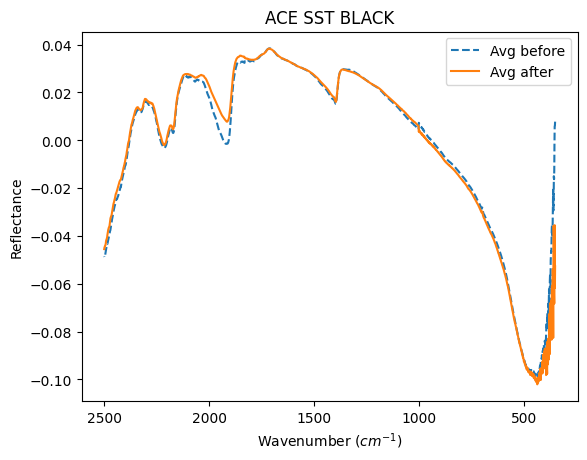

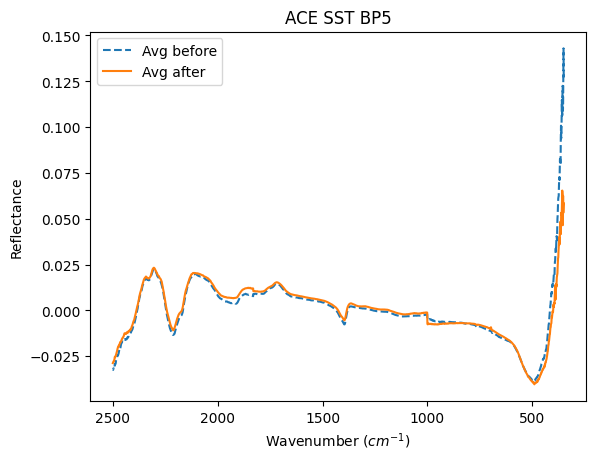

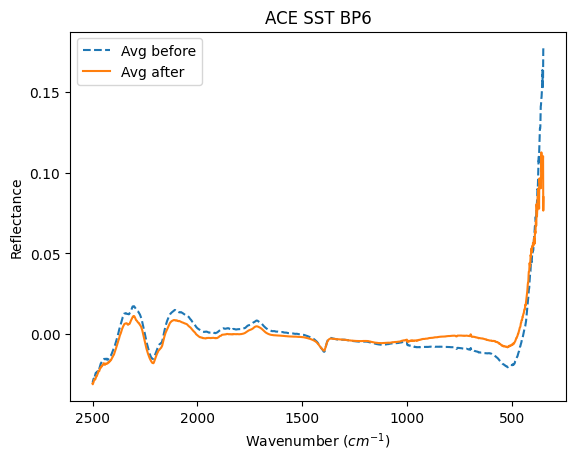

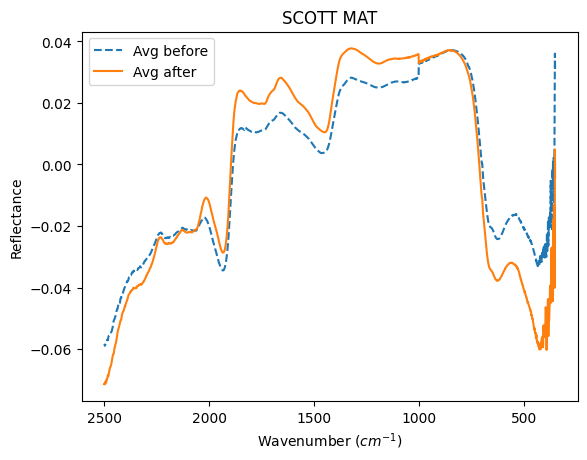

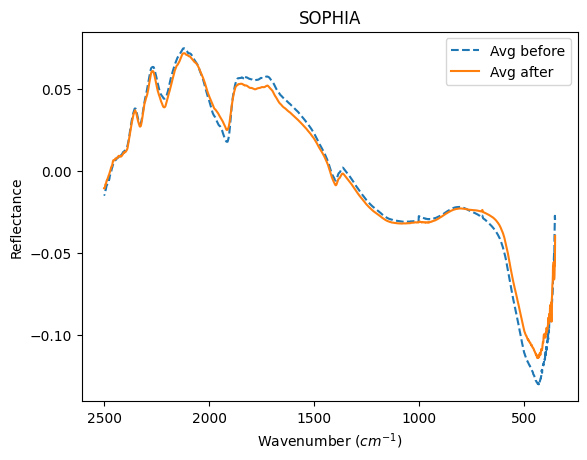

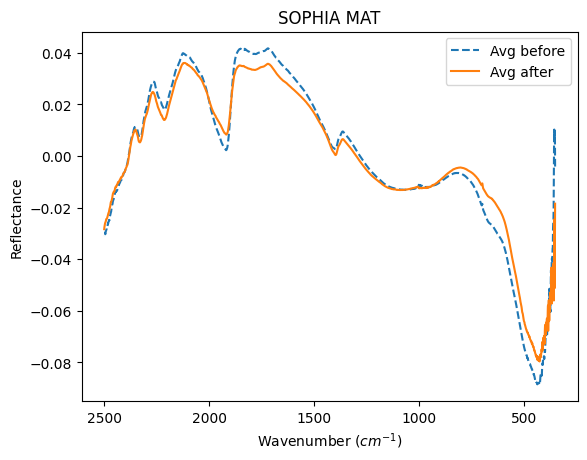

In [17]:
plot_before_after_ss_avg(BEFORE_VIS_NIR, AFTER_VIS_NIR, remove_average)

#### Absolute Intensity Differences

Comparing the averages for each sample allows us to visualise the differences more easily within each sample. To compare the effects of lyophilization across the samples, I want to compare the intensities between each subsample at every wavenumber and plot the differences from all samples on a single graph. For each sample, the difference at each wavelength, $\delta_\nu$, will be the sum of the differences between the intensity before and after lyophilization ($B$ and $A$ respectively) for each subsample ($n$ subsamples):

$\delta_\nu = \Sigma_{i}^n\Sigma_{j, i \neq j}^n A_i - B_j$

In [27]:
def plot_intensity_diff(before, after):
  fig, ax = plt.subplots()
  ax.set_title('Intensity differences before and after lyophilization')
  ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Intensity Increase After Lyophilization')

  for sample_before, subsamples_before in before.items():
    subsamples_after = after[sample_before]
    const_wavenumbers = subsamples_before[0][0]
    n_wavenumbers = len(const_wavenumbers)
    wavenumber_diffs = list(np.full(n_wavenumbers, 0))

    normalized_after = []
    for j in range(len(subsamples_after)):
      normalized_after.append(remove_average(subsamples_after[j][1]))

    for wavenumbers, intensities in subsamples_before:
      normlized_before = remove_average(intensities)
      for i in range(n_wavenumbers):
        wavenumber_diffs[i] += (normalized_after[j][i] - normlized_before[i])

    ax.plot(const_wavenumbers, wavenumber_diffs, '-', label=sample_before)
    
  ax.invert_xaxis()
  ax.legend()

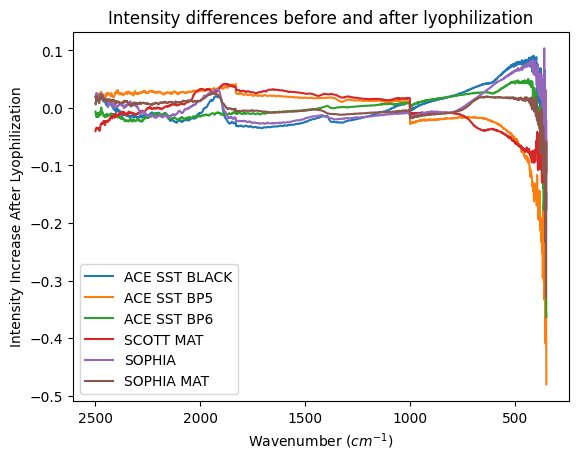

In [28]:
plot_intensity_diff(BEFORE_VIS_NIR, AFTER_VIS_NIR)

There are some noticeable differences around $1400cm^{-1}$, $1900cm^{-1}$, and $2200cm^{-1}$. These peaks at peaks at $1450cm^{-1}$ and $1950cm^{-1}$ <a href="https://doi.org/10.1016/S0016-7061(98)00023-8">may be attributed to OH bonds</a>, which we would expect from the lyophilization process. There are potentially more interesting differences around $700cm^{-1}$ and at $1600cm^{-1}$ in the SCOTT MAT sample. My next steps will be to continue investigating the differences found and finding ways to clean up the data and determine differences more accurtely. A notable area for cleanup will be at the lower wavenumbers - removing these values should help with visualisation and further analysis.

## MID IR Analysis

### Before Lyophilization 

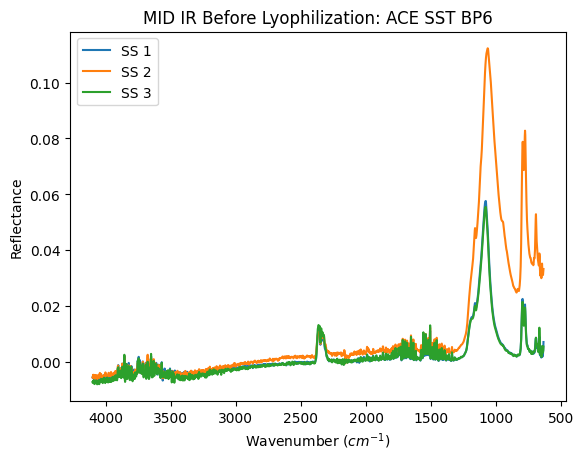

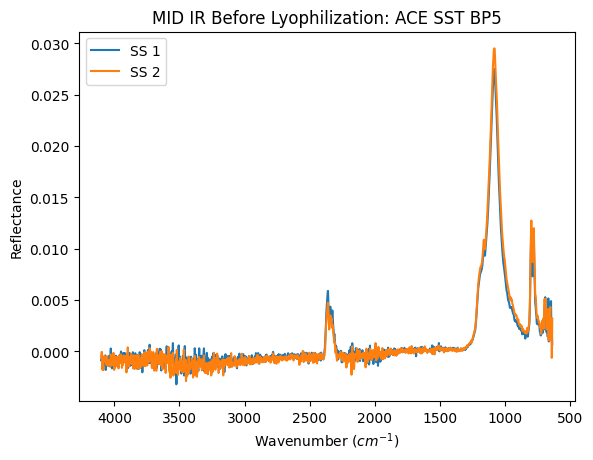

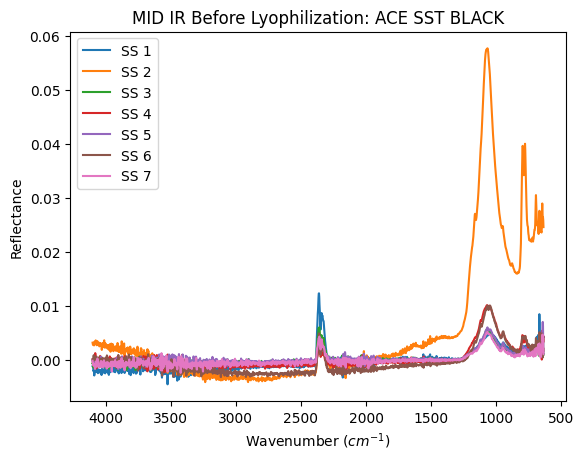

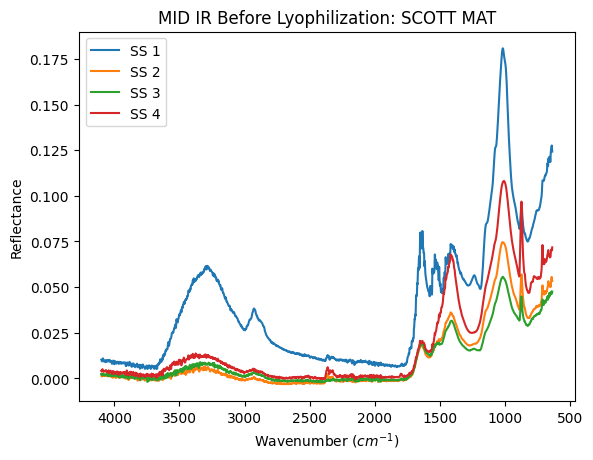

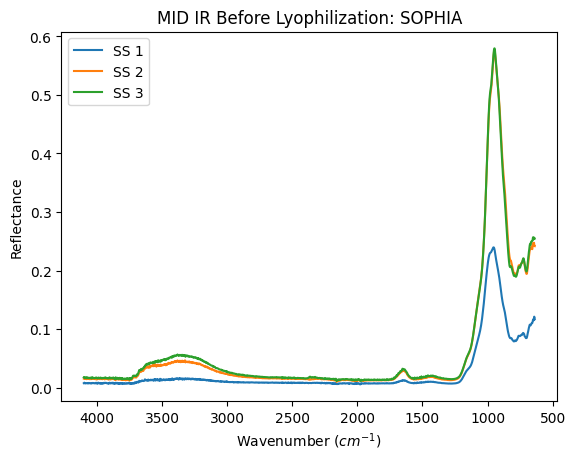

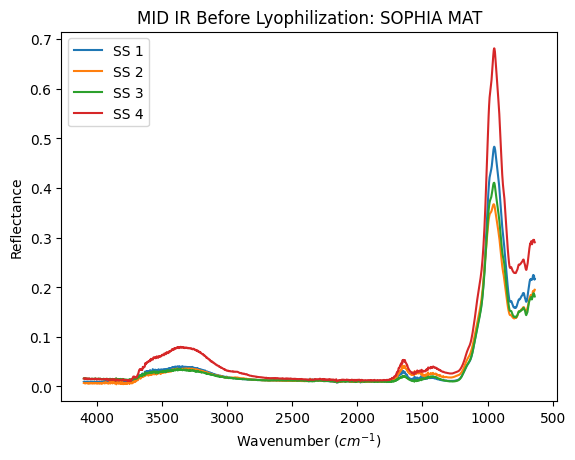

In [ ]:
plot_sample(BEFORE_MIR, 'MID IR Before Lyophilization')